# Running our model scripts in 'main'

## Loading in our Data

In [102]:
import os, requests
import numpy as np
import matplotlib.pyplot as plt

# For progress bars
from tqdm.notebook import tqdm

# So we will print out all of our trials in our jupyter notebook
np.set_printoptions(threshold=300)

In [103]:
# Getting our data from the steinmetz data set
# %run download.py

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
for j in range(len(fname)):
  os.remove('steinmetz_part%d.npz'%j)
np.save("alldata",alldat)

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

NB: that the time point data other than the spike (gocue, response_time, etc are all time linked to the stimulus presentation time).

The recordings also just come from the left hemisphere.

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played. (this is relative to 0?)
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [122]:
mouse_num = 7
cur_mouse = alldat[mouse_num]
cur_mouse_spks = cur_mouse['spks']
print(cur_mouse_spks.shape)
print(cur_mouse_spks[1].shape)

print(cur_mouse['brain_area'])

(1156, 250, 250)
(250, 250)
['ILA' 'TT' 'ILA' ... 'DG' 'DG' 'DG']


In [126]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

#-- Selecting a particular brain region for analysis --#
brain_region = 'MOs'

# Creating a mask for MOs, and exploring amount in each region
MOs_mask = brain_region == cur_mouse['brain_area']
print(f"Number of Neurons in brain region for mouse {mouse_num}:", sum(MOs_mask))

# Collecting the number of neurons in given region for all mice:
mouse_region_arr = np.zeros(len(alldat))
for i in range(len(alldat)):
    mouse_select = alldat[i]
    region_mask = brain_region == mouse_select['brain_area']
    total_neurons_region = sum(region_mask)
    mouse_region_arr[i] = total_neurons_region
    
print(mouse_region_arr)


Number of Neurons in brain region for mouse 7: 112
[113.   0.   0.  92.  29.   0.   0. 112.   0.   0.   0.   6.  46. 186.
   0.   0.   0.   0.   0.   0.   0.  65.   0.   0.  80. 166.  97.   0.
   0.  38. 281.  69.   0.   0.  34.  41. 233.   0.  54.]


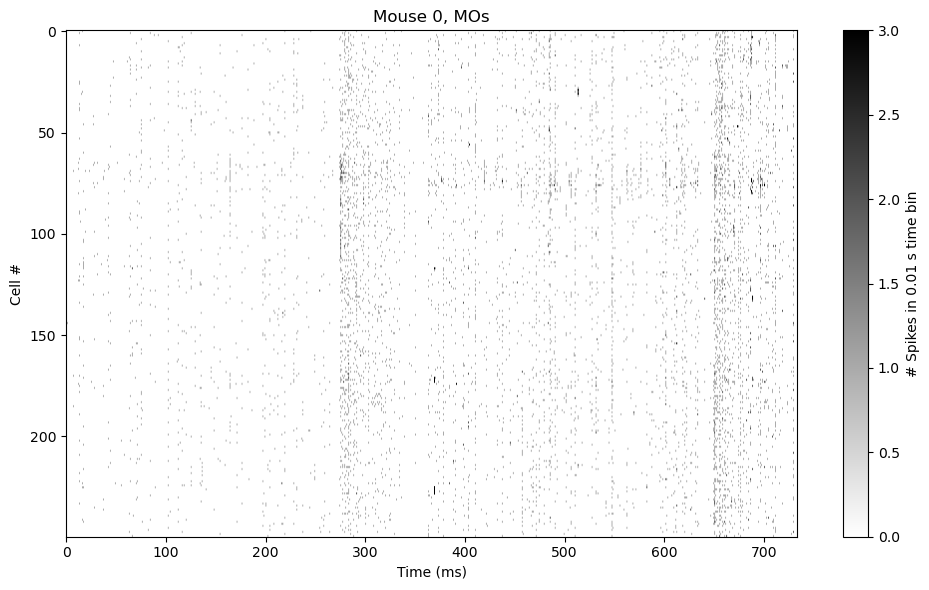

In [92]:
# Selecting out the trials for one mouse:


# Plotting a raster of our neurons for the trial:
fig, ax = plt.subplots(figsize = (10,6))
cb = ax.imshow(cur_mouse_spks[:, 0, :].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Cell #')
ax.set_title(f"Mouse {mouse_num}, MOs")
fig.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin', ax = ax, mappable = cb)
plt.tight_layout()

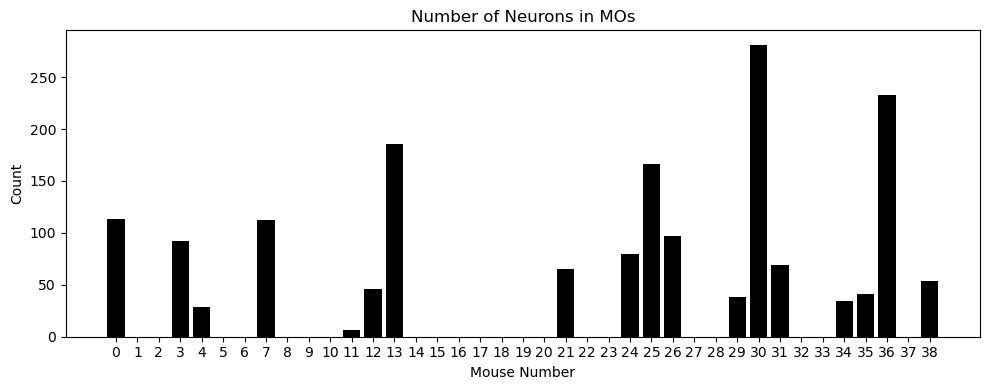

In [147]:
# Plotting a bar plot of the number of neurons in our given brain region for each mouse
fig, ax = plt.subplots(figsize = (10,4))

ax.bar(np.arange(len(mouse_region_arr)),mouse_region_arr, color = 'black', width = .8)
ax.set_xticks(np.arange(len(mouse_region_arr)));

# Axis formatting
ax.set_title(f"Number of Neurons in {brain_region}")
ax.set_ylabel('Count')
ax.set_xlabel('Mouse Number')

plt.tight_layout()
plt.savefig('NeuronRegionCount.png', dpi = 300)

# Processing our Data

In [ ]:
# Pulling in all our data, and processing it:



In [ ]:
# Training our model


In [5]:
# Using our ipython magic commands to run files
%run model.py

In [8]:
# # Running our optuna hyperparameter optimization
# %run modelling.py

The device we are using is:,  mps
Maximum data length = 89
Number of std's above baseline for first threshold:  2
Number of data points for second threshold:  10


  0%|          | 0/39 [00:00<?, ?it/s]

Total Failures to detect onset:  1876


[I 2023-07-26 09:15:07,099] Using an existing study with name 'flatbrain' instead of creating a new one.
Best valid loss: 26.60209083557129:   2%|     | 40/2000 [00:33<27:26,  1.19it/s]
/Users/johnbuggeln/miniconda3/envs/MLenv/lib/python3.10/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
[W 2023-07-26 09:15:41,058] Trial 379 failed with parameters: {'cut': 50, 'dropout': 0, 'hidden_size': 64, 'l2': 0.1, 'lr': 0.001, 'model_arch': 'lstm', 'num_layers': 4} because of the following error: ValueError('Input y_pred contains NaN.').
Traceback (most recent call last):
  File "/Users/johnbuggeln/miniconda3/envs/MLenv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/Users/johnbuggeln/Desktop/NMAproject/modelling.py", line 79, in optim
    return model.cross_validate(X_t, y)
  File "/Users/johnbuggeln/Desktop/NMAproject/

ValueError: Input y_pred contains NaN.